In [1]:
!pip install --quiet statsmodels

import pandas as pd, numpy as np, os, matplotlib.pyplot as plt, seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from math import sqrt
sns.set(style="whitegrid", rc={"figure.figsize": (10,6)})
OUTPUT_DIR = "veggiebell_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [2]:
FILE_PATH = "/content/Daily sales summary 1.1.25 to 20.6.25.csv"
df = pd.read_csv(FILE_PATH)
df.head()


,Sr.No,Sales Date,Gross Amount,Tax Amount,CGST,SGST,IGST,5%,12%,18%,28%,CESS,Discount,Bank,Cash,Credit Note,Coupon Discount,Additional Charge,Total
0,1.0,01/01/2025,961.55,54.0,27.0,27.0,0.0,0.0,54.0,0.0,0.0,0.0,0.00,1016.0,0.0,0.0,0.0,0.0,1016.0
1,2.0,02/01/2025,1449.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159.60,0.0,1450.0,0.0,0.0,0.0,1450.0
2,3.0,03/01/2025,6907.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,378.94,3398.0,3509.0,0.0,0.0,0.0,6907.0
3,4.0,04/01/2025,959.74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,959.0,0.0,0.0,0.0,959.0
4,5.0,06/01/2025,769.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,769.0,0.0,0.0,0.0,769.0


In [3]:
print(df.columns.tolist())


['Sr.No', 'Sales Date', 'Gross Amount', 'Tax Amount', 'CGST', 'SGST', 'IGST', '5%', '12%', '18%', '28%', 'CESS', 'Discount', 'Bank', 'Cash', 'Credit Note', 'Coupon Discount', 'Additional Charge', 'Total']


In [4]:
df.rename(columns={
    'Sales Date': 'sales_date',
    'Discount': 'discount',
    'Cash': 'cash',
    'Bank': 'bank',
    'Total': 'total'
}, inplace=True)


In [5]:
df['sales_date'] = pd.to_datetime(df['sales_date'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['sales_date']).copy()

df['month'] = df['sales_date'].dt.month_name()
df['weekday'] = df['sales_date'].dt.day_name()
df['week_start'] = df['sales_date'].dt.to_period('W').apply(lambda r: r.start_time)


In [6]:
df.head(3)


,Sr.No,sales_date,Gross Amount,Tax Amount,CGST,SGST,IGST,5%,12%,18%,...,discount,bank,cash,Credit Note,Coupon Discount,Additional Charge,total,month,weekday,week_start
0,1.0,2025-01-01,961.55,54.0,27.0,27.0,0.0,0.0,54.0,0.0,...,0.00,1016.0,0.0,0.0,0.0,0.0,1016.0,January,Wednesday,2024-12-30
1,2.0,2025-01-02,1449.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,159.60,0.0,1450.0,0.0,0.0,0.0,1450.0,January,Thursday,2024-12-30
2,3.0,2025-01-03,6907.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,378.94,3398.0,3509.0,0.0,0.0,0.0,6907.0,January,Friday,2024-12-30


/tmp/ipython-input-2944165577.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[str(p) for p in monthly_sales.index.astype(str)], y=monthly_sales.values, palette="crest")


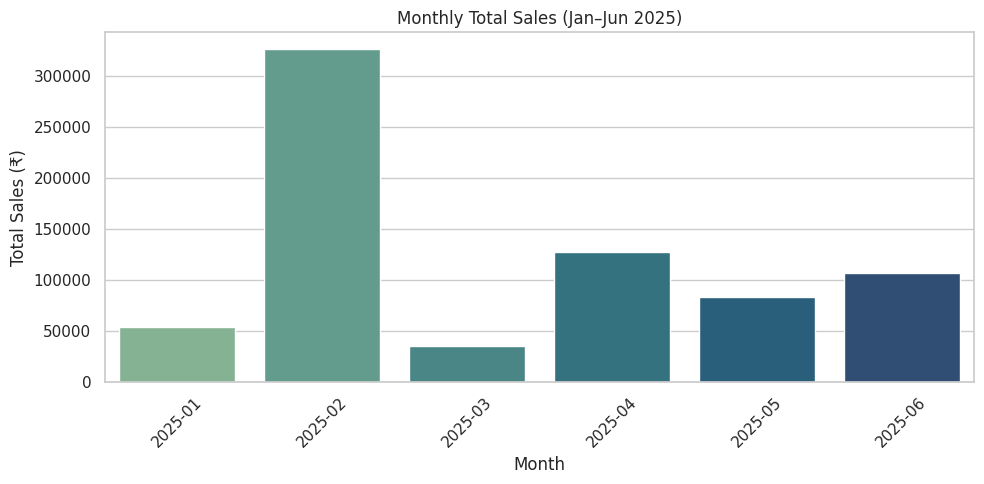

/tmp/ipython-input-2944165577.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette="mako")


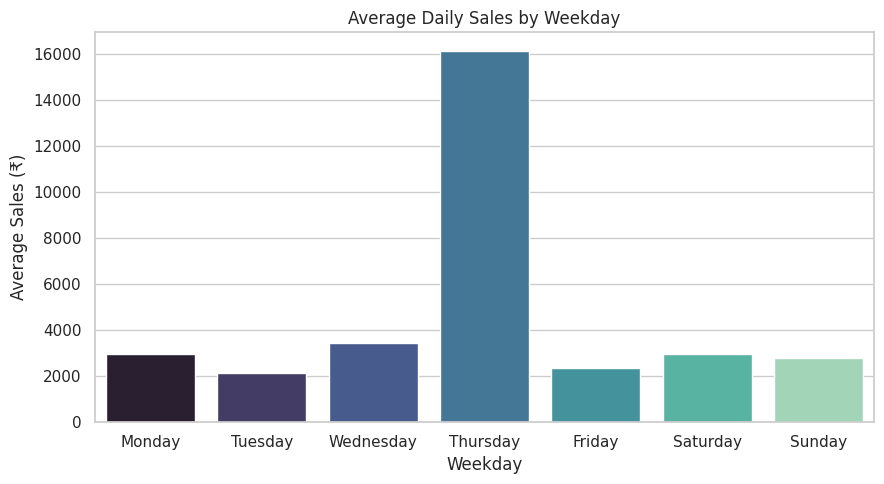

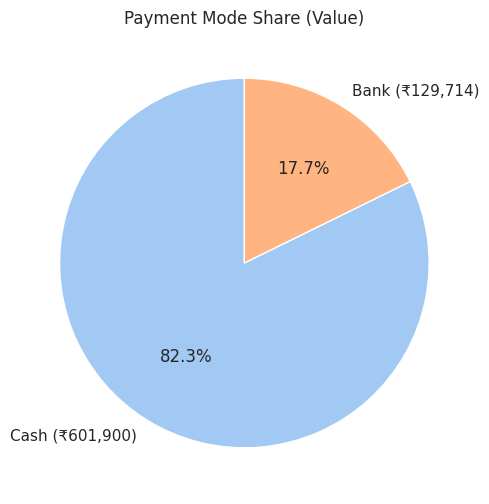

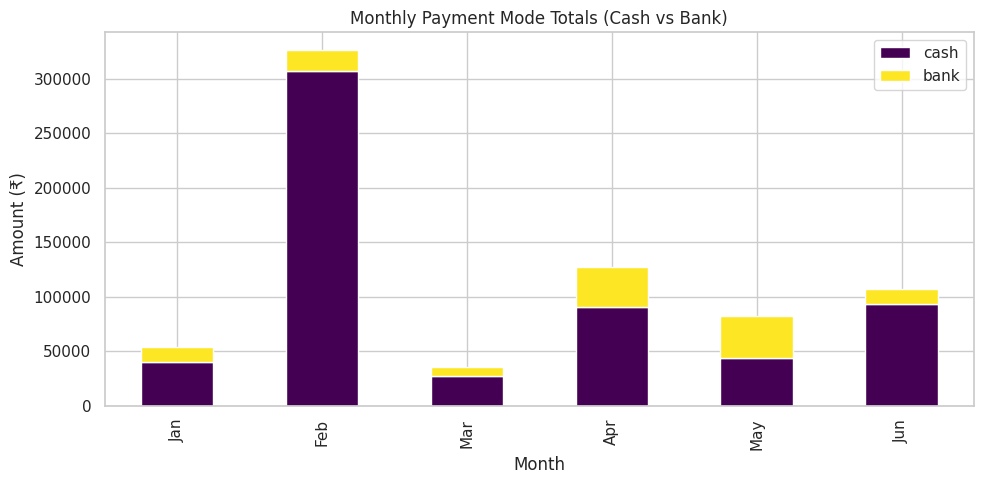

MONTHLY SALES TOTALS (₹):
sales_date
2025-01     53849.0
2025-02    326050.0
2025-03     35515.0
2025-04    126905.0
2025-05     82676.0
2025-06    106619.0
Freq: M, Name: total, dtype: float64

AVERAGE SALES BY WEEKDAY (₹):
weekday
Monday        2962.73
Tuesday       2152.67
Wednesday     3459.32
Thursday     16124.87
Friday        2351.18
Saturday      2980.09
Sunday        2795.59
Name: total, dtype: float64

PAYMENT MODE TOTALS:
  Cash: ₹601,900
  Bank: ₹129,714


In [7]:

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", rc={"figure.figsize": (10,6)})

monthly_sales = df.groupby(df['sales_date'].dt.to_period('M'))['total'].sum().sort_index()
plt.figure(figsize=(10,5))
sns.barplot(x=[str(p) for p in monthly_sales.index.astype(str)], y=monthly_sales.values, palette="crest")
plt.title("Monthly Total Sales (Jan–Jun 2025)")
plt.xlabel("Month")
plt.ylabel("Total Sales (₹)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_avg = df.groupby('weekday')['total'].mean().reindex(weekday_order)
plt.figure(figsize=(9,5))
sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette="mako")
plt.title("Average Daily Sales by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Average Sales (₹)")
plt.tight_layout()
plt.show()

if {'cash','bank'}.issubset(df.columns):
    cash_sum = df['cash'].sum()
    bank_sum = df['bank'].sum()
    plt.figure(figsize=(6,6))
    plt.pie(
        [cash_sum, bank_sum],
        labels=[f"Cash (₹{cash_sum:,.0f})", f"Bank (₹{bank_sum:,.0f})"],
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("pastel")[:2]
    )
    plt.title("Payment Mode Share (Value)")
    plt.show()

if {'cash','bank'}.issubset(df.columns):
    monthly_pay = (
        df.groupby(df['sales_date'].dt.strftime('%b'))[['cash','bank']]
        .sum()
        .reindex(['Jan','Feb','Mar','Apr','May','Jun'])
        .fillna(0)
    )
    monthly_pay.plot(kind='bar', stacked=True, figsize=(10,5), colormap='viridis')
    plt.title("Monthly Payment Mode Totals (Cash vs Bank)")
    plt.xlabel("Month")
    plt.ylabel("Amount (₹)")
    plt.tight_layout()
    plt.show()

print("MONTHLY SALES TOTALS (₹):")
print(monthly_sales.round(2))
print("\nAVERAGE SALES BY WEEKDAY (₹):")
print(weekday_avg.round(2))
if {'cash','bank'}.issubset(df.columns):
    print("\nPAYMENT MODE TOTALS:")
    print(f"  Cash: ₹{cash_sum:,.0f}")
    print(f"  Bank: ₹{bank_sum:,.0f}")


In [8]:
df.rename(columns={
    'Sales Date': 'sales_date',
    'Gross Amount': 'gross_amount',
    'Discount': 'discount',
    'Bank': 'bank',
    'Cash': 'cash',
    'Total': 'total'
}, inplace=True)


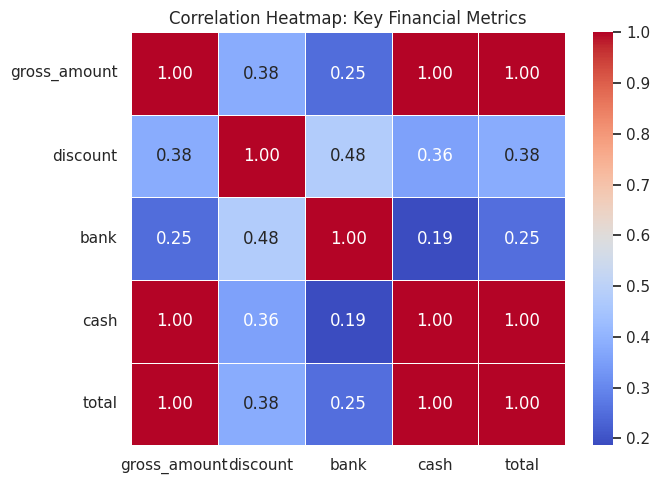

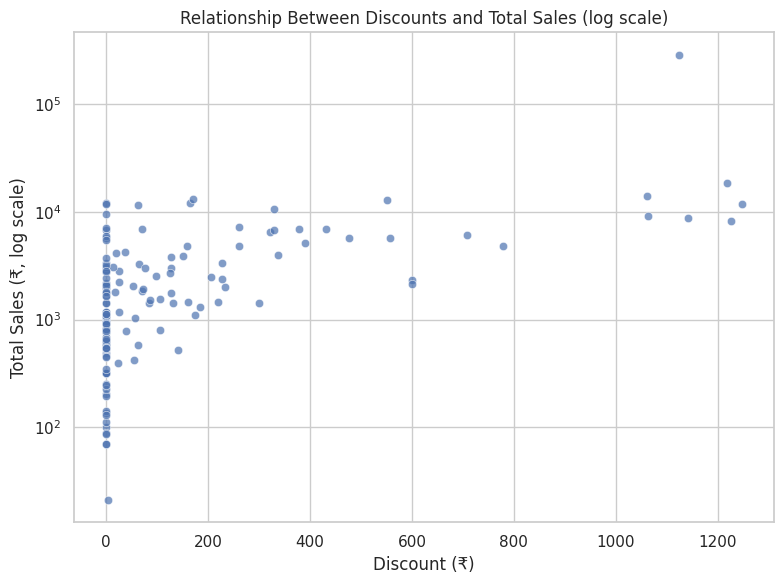

Pearson correlation between Discount and Total Sales: 0.383
Interpretation: Weak correlation — discounts do not strongly influence total sales volume.


In [9]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

num_cols = ['gross_amount','discount','bank','cash','total']
corr_df = df[num_cols].corr(method='pearson')

plt.figure(figsize=(7,5))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Key Financial Metrics")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x='discount', y='total', data=df, alpha=0.7)
plt.yscale('log')  # helps when sales vary widely
plt.title("Relationship Between Discounts and Total Sales (log scale)")
plt.xlabel("Discount (₹)")
plt.ylabel("Total Sales (₹, log scale)")
plt.tight_layout()
plt.show()

corr_val = df['discount'].corr(df['total'])
print(f"Pearson correlation between Discount and Total Sales: {corr_val:.3f}")

if corr_val > 0.4:
    print("Interpretation: A positive correlation — higher discounts tend to increase total sales.")
elif corr_val < -0.4:
    print("Interpretation: A strong negative correlation — higher discounts may be given when sales are weak.")
else:
    print("Interpretation: Weak correlation — discounts do not strongly influence total sales volume.")


ABC CLASS SUMMARY (based on day-level contribution):
           count       sum  revenue_pct
ABC_Class                              
A             38  584657.0    79.913315
B             52  110170.0    15.058487
C             63   36787.0     5.028198


/tmp/ipython-input-2192655406.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=abc_table.index, y=abc_table['revenue_pct'], palette='viridis')


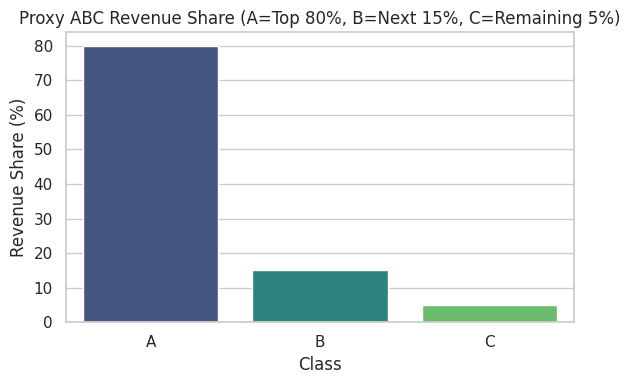

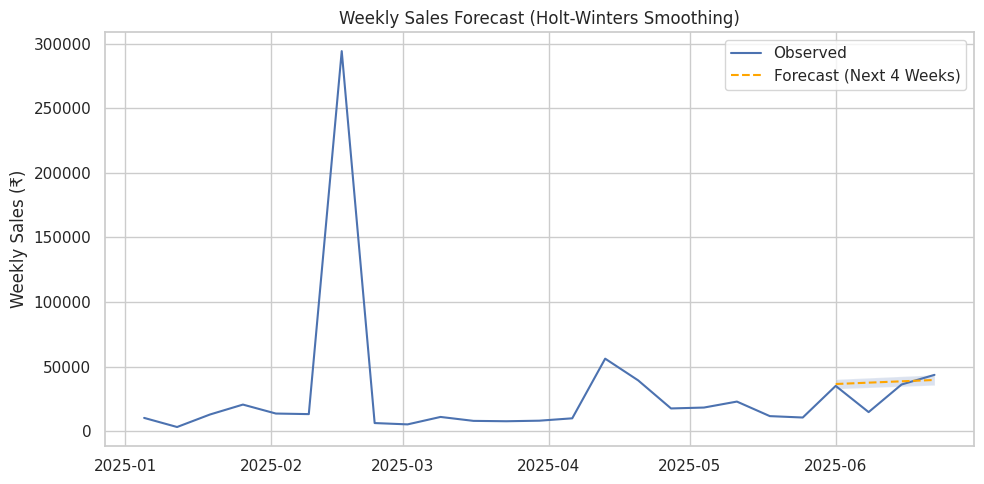

Forecasted Weekly Totals (₹):
2025-06-01    36563.541345
2025-06-08    37604.536771
2025-06-15    38645.532198
2025-06-22    39686.527624
Freq: W-SUN, dtype: float64


In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df_sorted = df.sort_values('total', ascending=False).reset_index(drop=True)
df_sorted['cum_revenue'] = df_sorted['total'].cumsum()
df_sorted['cum_pct'] = df_sorted['cum_revenue'] / df_sorted['total'].sum()

def classify_abc(p):
    if p <= 0.8:
        return 'A'
    elif p <= 0.95:
        return 'B'
    else:
        return 'C'

df_sorted['ABC_Class'] = df_sorted['cum_pct'].apply(classify_abc)

abc_table = df_sorted.groupby('ABC_Class')['total'].agg(['count', 'sum'])
abc_table['revenue_pct'] = (abc_table['sum'] / df['total'].sum()) * 100
print("ABC CLASS SUMMARY (based on day-level contribution):")
print(abc_table)

plt.figure(figsize=(6,4))
sns.barplot(x=abc_table.index, y=abc_table['revenue_pct'], palette='viridis')
plt.title("Proxy ABC Revenue Share (A=Top 80%, B=Next 15%, C=Remaining 5%)")
plt.ylabel("Revenue Share (%)")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

weekly_sales = df.set_index('sales_date').resample('W')['total'].sum()

train = weekly_sales.iloc[:-4]
test = weekly_sales.iloc[-4:]

model = ExponentialSmoothing(train, trend='add', seasonal=None, initialization_method='estimated')
fit = model.fit()
forecast = fit.forecast(steps=4)

plt.figure(figsize=(10,5))
plt.plot(weekly_sales.index, weekly_sales.values, label='Observed')
plt.plot(forecast.index, forecast.values, label='Forecast (Next 4 Weeks)', linestyle='--', color='orange')
plt.fill_between(forecast.index, forecast.values*0.9, forecast.values*1.1, alpha=0.2)
plt.title("Weekly Sales Forecast (Holt-Winters Smoothing)")
plt.ylabel("Weekly Sales (₹)")
plt.legend()
plt.tight_layout()
plt.show()

print("Forecasted Weekly Totals (₹):")
print(forecast)


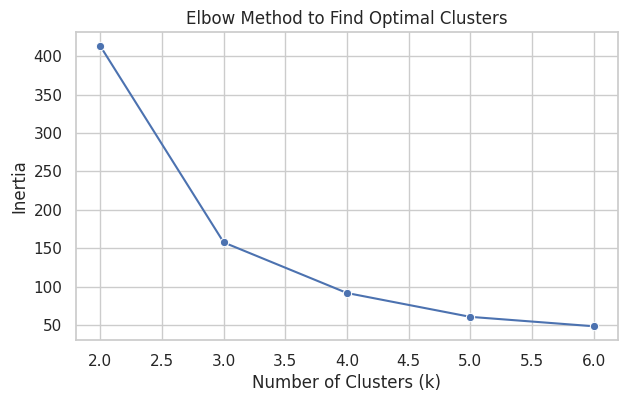

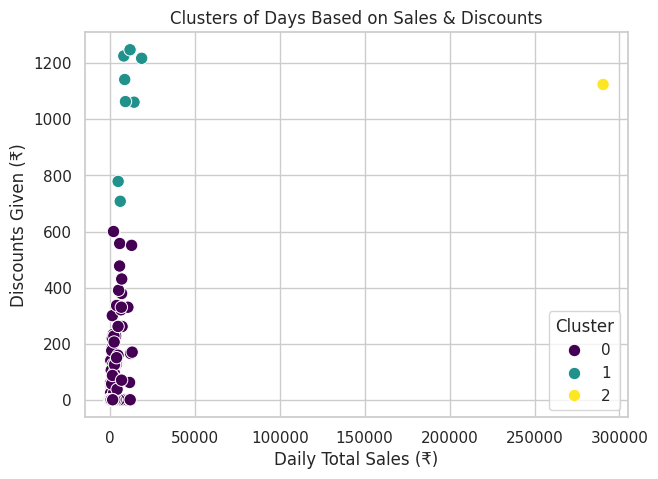

CLUSTER SUMMARY (Average values per group):
             total  discount       cash     bank
cluster                                         
0          2495.84     73.08    1845.12   650.72
1         10232.88   1055.62    6225.00  4007.88
2        290350.00   1124.40  286402.00  3948.00


In [11]:

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

daily_summary = df.groupby('sales_date').agg({
    'total': 'sum',
    'discount': 'sum',
    'cash': 'sum',
    'bank': 'sum'
}).reset_index()

features = ['total', 'discount', 'cash', 'bank']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(daily_summary[features])

inertia = []
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7,4))
sns.lineplot(x=range(2,7), y=inertia, marker="o")
plt.title("Elbow Method to Find Optimal Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
daily_summary['cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(7,5))
sns.scatterplot(
    x=daily_summary['total'],
    y=daily_summary['discount'],
    hue=daily_summary['cluster'],
    palette='viridis',
    s=80
)
plt.title("Clusters of Days Based on Sales & Discounts")
plt.xlabel("Daily Total Sales (₹)")
plt.ylabel("Discounts Given (₹)")
plt.legend(title="Cluster")
plt.show()

cluster_summary = daily_summary.groupby('cluster')[features].mean().round(2)
print("CLUSTER SUMMARY (Average values per group):")
print(cluster_summary)


In [12]:
print(df.columns.tolist())


['Sr.No', 'sales_date', 'gross_amount', 'Tax Amount', 'CGST', 'SGST', 'IGST', '5%', '12%', '18%', '28%', 'CESS', 'discount', 'bank', 'cash', 'Credit Note', 'Coupon Discount', 'Additional Charge', 'total', 'month', 'weekday', 'week_start']


Model R² Score: 1.000
Mean Absolute Error: ₹0.00

Feature Importance (by Coefficient Magnitude):
       Feature   Coefficient
1         cash  1.000000e+00
2         bank  1.000000e+00
0     discount  2.070787e-14
3  weekday_num -2.522015e-13


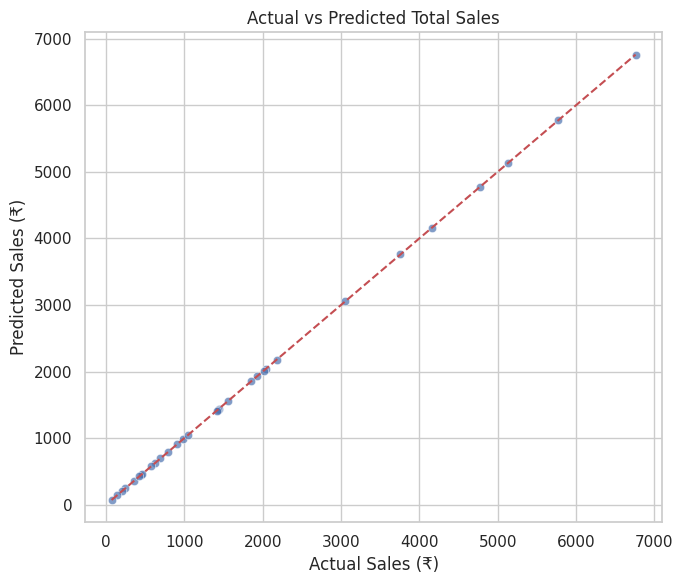

/tmp/ipython-input-225704061.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Coefficient', data=coeff_df, palette='crest')


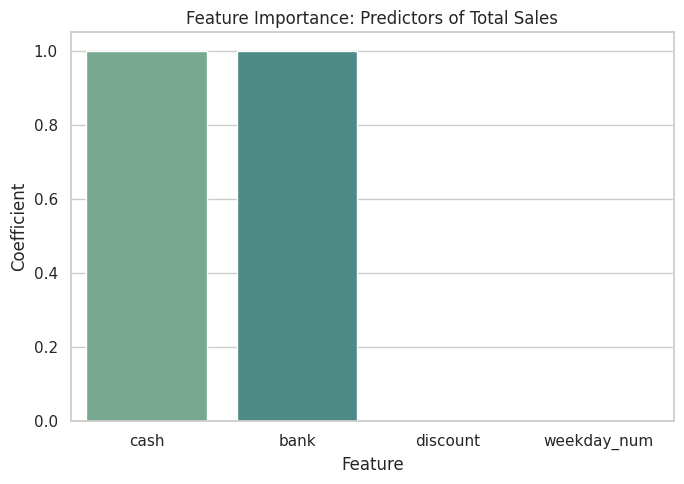

In [13]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

df['weekday_num'] = df['weekday'].astype('category').cat.codes


X = df[['discount', 'cash', 'bank', 'weekday_num']]
y = df['total']

X = X.fillna(0)
y = y.fillna(0)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Model R² Score: {r2:.3f}")
print(f"Mean Absolute Error: ₹{mae:.2f}")

coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance (by Coefficient Magnitude):")
print(coeff_df)


plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.xlabel("Actual Sales (₹)")
plt.ylabel("Predicted Sales (₹)")
plt.title("Actual vs Predicted Total Sales")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
sns.barplot(x='Feature', y='Coefficient', data=coeff_df, palette='crest')
plt.title("Feature Importance: Predictors of Total Sales")
plt.tight_layout()
plt.show()
